# Price recommendation system for OLX cars announcements
The aim of this project is to create machine learning model to suggest car price in advertisements. 

The recommendation will help users to establish initial price based on information about vehicle.

The source of the data is listed below:

https://www.kaggle.com/datasets/abdullahkhanuet22/olx-cars-dataset

## Load packages and data

In [1]:
import pandas as pd 
import numpy as np 
import os 
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from functions import kaggle_download, barplot_share, info_splitter, calc_split_summary, bubble_plot
import lightgbm as lgb 
import optuna
seed=123
%matplotlib inline
import plotly.io as pio
pio.renderers.default = "svg"


In [2]:
kaggle_download(user='abdullahkhanuet22',dataset='olx-cars-dataset')

In [3]:
data = pd.read_csv('OLX_cars_dataset.csv')

## Data understanding
The first step is to take a brief look at data and evaluate it.

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8721 entries, 0 to 8720
Data columns (total 18 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Ad ID              8721 non-null   int64 
 1   Car Name           8721 non-null   object
 2   Make               8721 non-null   object
 3   Model              8721 non-null   object
 4   Year               8721 non-null   int64 
 5   KM's driven        8721 non-null   int64 
 6   Price              8721 non-null   int64 
 7   Fuel               8721 non-null   object
 8   Registration city  8721 non-null   object
 9   Car documents      8721 non-null   object
 10  Assembly           8721 non-null   object
 11  Transmission       8721 non-null   object
 12  Condition          8721 non-null   object
 13  Seller Location    8721 non-null   object
 14  Description        8721 non-null   object
 15  Car Features       8721 non-null   object
 16  Images URL's       8721 non-null   object


- Dataset cointains 8721 records which is a fair sample for the excercises purpose. 
- It doesn't contain any missing data. 
- Most of the variables are strings/ categorical.
- Only 'Price' (which is target to the model), 'Year' (of production) and KM's driven (kilometers driven)  are integers.
- It would be difficult to use the model with 'Year' as a variable, that's why a new variable 'Age' of the car will be calculated (in years). There is no information about data collection date, so 'Age' is calculated based on the most current year which is 2024.

In [5]:
data['Age'] = data['Year'].max() - data['Year']

## Features analysis & engineering
### Numerical features

In [6]:
numerical_features = ["KM's driven","Age","Price"]

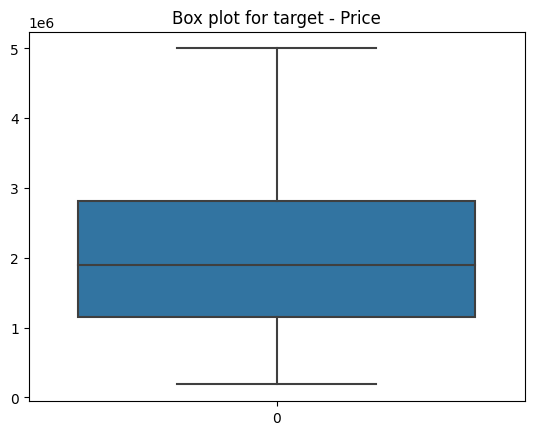

In [7]:
sns.boxplot(data['Price'])
plt.title('Box plot for target - Price')
plt.show()

Box plot suggests there is no outliers in Price.

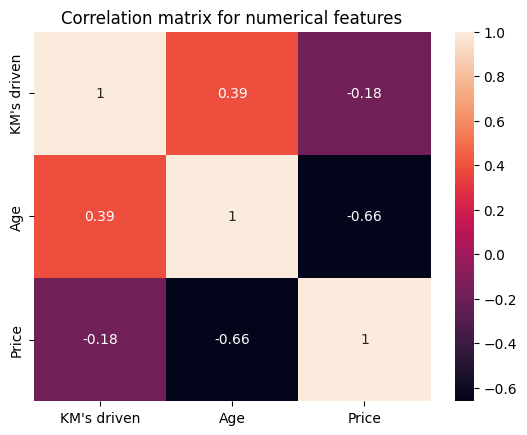

In [8]:
sns.heatmap(data[numerical_features].corr(),annot=True)
plt.title('Correlation matrix for numerical features')
plt.show()

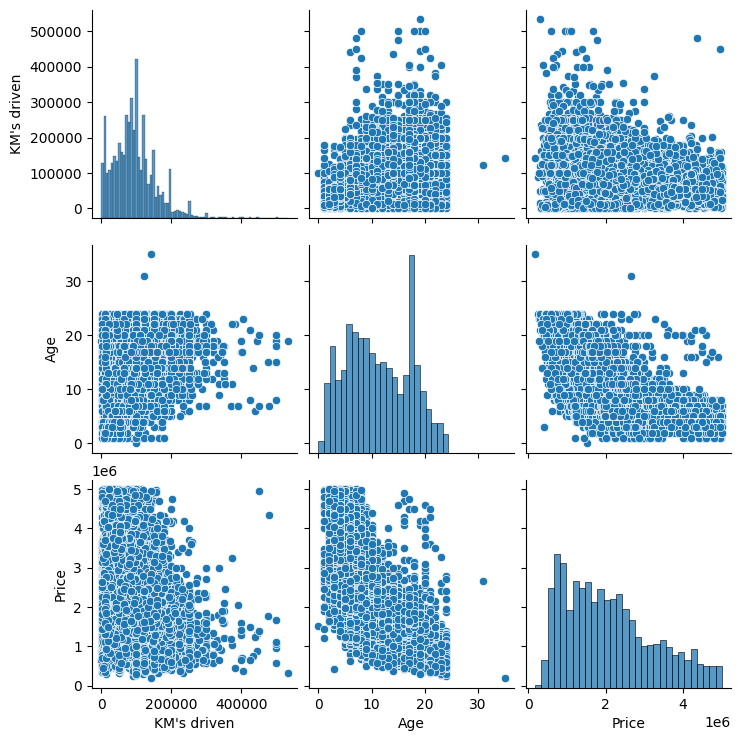

In [9]:
sns.pairplot(data[numerical_features])
plt.show()

Above plots show negtive correlation between age of the car and price. The kilometers made by the car have much lower impact on price. Scatter plot for 8000 cases can be illegible and it is only an additional information - small trend in both - Age and KM's driven and Price can be observed. Histograms indicate good size of all ranges of the variables. Lack of cases above 25 years and 300 000 km should be higlihted to not use the model for values outside of the train set range. 

In [10]:
data[numerical_features].describe()

,KM's driven,Age,Price
count,8721.000000,8721.000000,8.721000e+03
mean,95348.594198,11.328288,2.097328e+06
std,61550.623242,5.912057,1.157404e+06
min,1.000000,0.000000,1.850000e+05
25%,52000.000000,6.000000,1.150000e+06
50%,90000.000000,11.000000,1.900000e+06
75%,124000.000000,17.000000,2.820000e+06
max,533528.000000,35.000000,5.000000e+06


Maximum value for 'Age' and  'KM's driven' is equal to 35 and 530 000 respectively. However, there is not enough data point around that values to use them (based on qaurtiles) in the final solution. Additional quantiles will be checked.

In [11]:
data[numerical_features].quantile([0.95,0.98,0.99])

,KM's driven,Age,Price
0.95,200000.0,21.0,4350000.0
0.98,250000.0,23.0,4700000.0
0.99,284208.0,24.0,4850000.0


The recommendation system shouldn't be used for cars with Age>23 (0.98 quantile) and KM's driven >250 000.



### Categorical variables
The most typical categorical features are 'Car Name' / model of the car and 'Make' (Manufacturer).

Car name is a variable with a high variety of categories, so it will not be taken under consideration for now.

In [12]:
data['Car Name'].value_counts()

Honda City                                 33
Suzuki Bolan                               28
Honda city                                 23
Suzuki bolan                               23
urgent sale                                19
                                           ..
Honda City Vario Auto Transmission 2008     1
Honda city steermatic                       1
Honda city 2004 automatic transmission      1
honda city 2004                             1
Yaris 2021                                  1
Name: Car Name, Length: 7557, dtype: int64

### 'Make' variable

In [13]:
data['Make'].value_counts()

Suzuki        3048
Honda         1758
Toyota        1606
Daihatsu      1373
Mitsubishi     249
KIA            234
Changan        192
FAW            137
Chevrolet       77
Mercedes        45
Hyundai          2
Name: Make, dtype: int64

There are 11 different manufacturers, some of them need to be marged because of being sparse.
To merged that correctly - similarity analysis is conducted below. 

In [14]:
prices = bubble_plot(df=data,x='Price',y='Age',ids_col = 'Ad ID',groupper = 'Make',list_to_change_location=['Chevrolet'],agg_func = np.mean)
# Display the interactive Plotly plot using an IFrame
#IFrame(src='/iframe_figures/figure_54.html', width='100%', height=600)

Above plot and summary show average price and age by make. Size of the bubbles on the plot indicates number of advertisment in the database.

In [15]:
prices_median = bubble_plot(df=data,x='Price',y='Age',ids_col = 'Ad ID',groupper = 'Make',list_to_change_location=['Chevrolet'],agg_func = np.median)

Above plot and summary show median price and age by make, while below the share of advertisments is listed.

In [16]:
barplot_share(data, 'Make')

There are four main producers in the database: 
- Suzuki
- Honda
- Toyota
- Daihatsu 

All of the above are Japan companies.

The share of the others implicates a need to merge them to the bigger groups.
There will be two variables created:
1. All of the manufacturers with number of ads lower than 3% will be merged to one group.
2. Based on the similarity in price and age (mean and median) seen on the bubble plot the manufacturers with share <3% will be grouped accordingly:
    - Mercedes and Changan will be grouped with Toyota (the closest average price).
    - Chevrolet, Hyundai and FAW will be grouped with Suzuki (the closest average price)
    - Mitshubishi and KIA will be merged to one group (the closest average price and age).


In [17]:
prices['Share of make'] =  np.round(prices['No of ads']/ prices['No of ads'].sum(),3)

In [18]:
makes_less_3_prct = prices.loc[prices['Share of make']<0.03,'Make'].values
makes_less_3_prct

array(['Changan', 'Chevrolet', 'FAW', 'Hyundai', 'KIA', 'Mercedes',
       'Mitsubishi'], dtype=object)

In [19]:
data['make_new_1'] = data.loc[:,'Make'].apply(lambda x: 'Others' if x in makes_less_3_prct  else x)

In [20]:
barplot_share(data, 'make_new_1')

##### Version 2

In [21]:
group_1 = ['Mercedes', 'Changan','Toyota']
group_2 = ['Chevrolet', 'Hyundai',  'FAW', 'Suzuki']
group_3 = ['Mitsubishi', 'KIA']

In [22]:
data['make_new_2'] = np.select([data['Make'].isin(group_1),
                                data['Make'].isin(group_2),
                                data['Make'].isin(group_3)],['Merc_chang_toy','chev_huy_faw_suz','mits_kia'], default=data['Make'])

In [23]:
barplot_share(data, 'make_new_2')

Both variables will be included in parameters optimization which will select the one with higher importance.

### Categorical Features

In [24]:
columns = [ 'Fuel',
            'Registration city',
            'Car documents',
            'Assembly',
            'Transmission' ,
            'Condition',
            'Seller Location' ]

Based on below summary variables Fuel, Assembly, Registration city and Transmission can be used as a model features.

In [25]:
for col in columns:
    print(data[col].value_counts())
    print('################\n')

Petrol    8540
CNG        179
Diesel       1
Hybrid       1
Name: Fuel, dtype: int64
################

Lahore         3213
Karachi        2643
Islamabad      1231
Sindh           464
Punjab          357
               ... 
Nawabshah         1
Haripur           1
Dadu              1
Mirpur Khas       1
Wazirabad         1
Name: Registration city, Length: 61, dtype: int64
################

Original     8661
Duplicate      60
Name: Car documents, dtype: int64
################

Local       5726
Imported    2995
Name: Assembly, dtype: int64
################

Manual       5189
Automatic    3532
Name: Transmission, dtype: int64
################

Used    8721
Name: Condition, dtype: int64
################

Gulshan-e-Iqbal, Karachi                  163
Johar Town, Lahore                         86
North Karachi, Karachi                     69
North Nazimabad, Karachi                   65
Federal B Area, Karachi                    63
                                         ... 
Asim Town, Lahor

In [26]:
columns = ['Fuel',
'Assembly',
'Transmission' ,
]

In [27]:
for col in columns:
    print(data[col].value_counts())
    print('################\n')

Petrol    8540
CNG        179
Diesel       1
Hybrid       1
Name: Fuel, dtype: int64
################

Local       5726
Imported    2995
Name: Assembly, dtype: int64
################

Manual       5189
Automatic    3532
Name: Transmission, dtype: int64
################



For fuel variable only 'petrol' value is significantly high, so the variable will be transformed to true/false variable (is petrol?)

In [28]:
data['is_petrol'] = data['Fuel'] =='Petrol'

In [29]:
barplot_share(data, 'is_petrol')

Only 2% of the cases are other than petrol fuel, so it won't be used in the model.

In [30]:
reg_city = data['Registration city'].value_counts() / data.shape[0] <0.03
big_cities=  reg_city[reg_city== False].index
data['registration_city'] = np.where(data['Registration city'].isin(big_cities),data['Registration city'],'Other')

In [31]:
barplot_share(data, 'registration_city')

In [32]:
barplot_share(data, 'Assembly')

In [33]:
barplot_share(data, 'Transmission')

### Check categorical variables relation with price

In [34]:
columns = ['make_new_1', 'make_new_2' , 'is_petrol', 'Assembly', 'registration_city' , 'Transmission']

In [35]:
for col in columns:
    df_to_plot = data[[col,'Price']].groupby(col).mean().reset_index().sort_values(by='Price',ascending=False)
    fig = px.bar(data_frame=df_to_plot, x=col, y='Price',title=f'Average Price by {col}', width = 600, height=400)
    fig.show()

All of the variables have impact on price. To make a second check distribution plot will be made for variables with two categories.

In [36]:
columns_short = [ 'is_petrol', 'Assembly', 'Transmission']

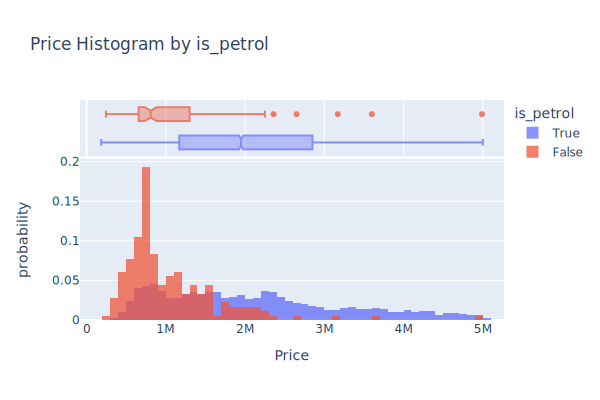

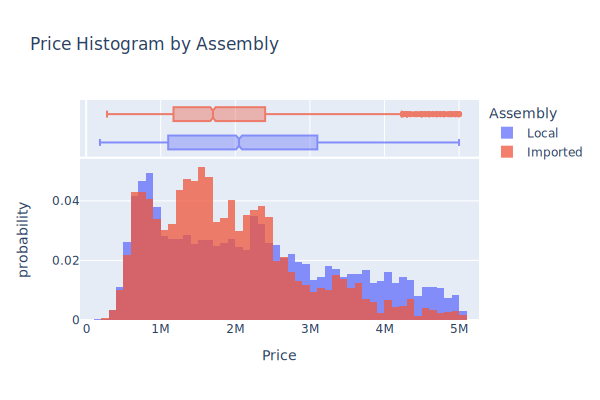

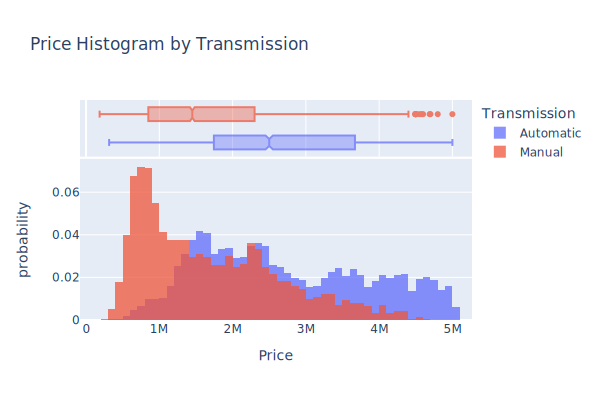

In [37]:
for col in columns_short:
    fig = px.histogram(data_frame=data,x='Price', color=col,marginal="box",histnorm='probability', title=f'Price Histogram by {col}', width = 600, height=400)
    fig.update_traces(opacity=0.75)
    fig.update_layout(barmode='overlay')
    fig.show('svg')

Above plots show histograms and box plots by subgroups (defined by chosen 0/1 variables). Box plots highlight differences of average and quartiles in each group. The minimum and maximum are the closest for 'Assembly'. 
The more separated two histograms are the more predictive power variable has. This can be observed the most in the 'Transmition' variable.

#### Car features
There is one more, interesting variable - car features. However, all features are stored in one column. Information will be split to separate columns.

In [38]:
data, all_features = info_splitter(data, 'Car Features',split = ', ')

In [39]:
calc_split_summary(data,all_features, calc_type=np.median)

,difference in Price,number_of_records - min
AM/FM Radio,114,3281
USB and Auxillary Cable,115,3923
Cassette Player,116,930
Cool Box,122,555
CD Player,123,3310
Alloy Rims,124,4349
Rear speakers,126,3190
Rear AC Vents,127,914
Heated Seats,132,504
DVD Player,132,1969


Minimum share of each car feature is greater than 3%, so all can be used as features in the model. Moreover, all of them differentiate median price. In the first step all of these features will be used and after first optimization the variables with the lowest importance will be excluded.

The processed data set will be saved to use in the modeling part.

In [40]:
data.to_csv('olx_cars_adjusted.csv')